In [4]:
!pip install matplotlib_inline

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import scipy.stats
import seaborn as sns
import numba

from numba.typed import List

from gnn_testbed.event_generation import (
    Detector,
    proposal_setup,
    generate_cascade,
    make_line
)

from gnn_testbed.plotting import plot_events, plot_event
from gnn_testbed.feature_generation import get_features
from gnn_testbed.event_generation.photon_propagation import BiolumiSource, generate_biolumi_photons, dejit_biolumi_sources
from gnn_testbed.event_generation.mc_record import MCRecord


In [121]:
dfs = pd.read_pickle("statistics_higher.p")

Text(0, 0.5, '# Emitters')

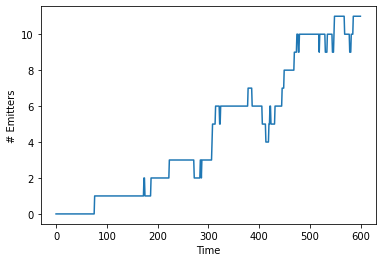

In [122]:
plt.plot([df["is_emitting"].sum() for df in dfs])
plt.xlabel("Time")
plt.ylabel("# Emitters")

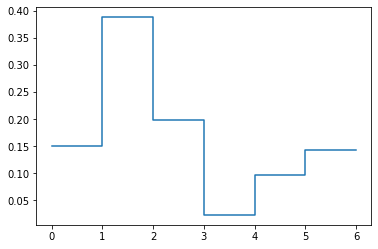

In [51]:

n_em_prob, edges = np.histogram([df["is_emitting"].sum() for df in dfs], bins=np.arange(7))
n_em_prob = n_em_prob / n_em_prob.sum()
plt.step(edges, np.append(n_em_prob, n_em_prob[-1]), where="post")

(1, 10000000000.0)

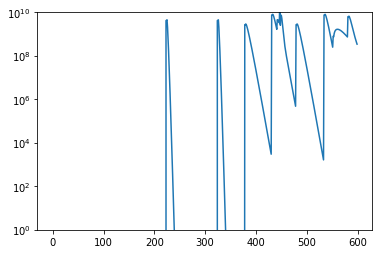

In [4]:
plt.plot([df["photons"].sum() for df in dfs])

mask = [df["photons"].sum() > 0 for df in dfs]
plt.semilogy()
plt.ylim(1, 1E10)

In [5]:
ix = np.argwhere(mask).ravel()[0]
dfs[ix][dfs[ix]["is_emitting"]]

,species,pos_x,pos_y,velocity,angle,radius,energy,observed,max_emission,emission fraction,...,pulse mean,pulse sd,pulse size,pulse start,is_emitting,emission_duration,encounter photons,shear photons,photons,is_injected
15,long pulse 1,18.47981,7.894448,0.0,0.0,0.000586,0.6148,True,-0.871640,0.2,...,2.0,1.5,1.000000e+10,False,True,63.0,0.0,-1.743281e+09,-3.140551e-04,True
24,Bathyctena chuni (Moser),2.72431,7.594436,0.0,0.0,0.000780,0.8001,True,5.810912,0.2,...,2.0,1.0,1.000000e+10,True,True,99.0,0.0,1.162182e+10,4.194248e+09,True


In [6]:
dfs[ix][dfs[ix]["is_emitting"] & (dfs[ix]["photons"] > 0)]

,species,pos_x,pos_y,velocity,angle,radius,energy,observed,max_emission,emission fraction,...,pulse mean,pulse sd,pulse size,pulse start,is_emitting,emission_duration,encounter photons,shear photons,photons,is_injected
24,Bathyctena chuni (Moser),2.72431,7.594436,0.0,0.0,0.00078,0.8001,True,5.810912,0.2,...,2.0,1.0,1.000000e+10,True,True,99.0,0.0,1.162182e+10,4.194248e+09,True


In [40]:
rng = np.random.RandomState(31338)
modules = make_line(0, 0, 20, 50, rng, 1e-6, 0)
modules += make_line(100, 0, 20, 50, rng, 1e-6, 0)
det = Detector(modules)

In [13]:
prob_model = pd.read_pickle("prob_model.p")
# fix artifacts
prob_model[2][:30, :] = 0
prob_model[2][120:, :] = 0
plt.pcolormesh(prob_model[0], prob_model[1], prob_model[2])

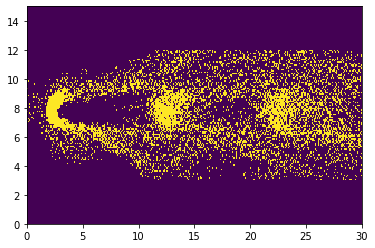

In [98]:
weights = prob_model[2].ravel()
weights /= weights.sum()


ix = np.random.choice(np.arange(len(weights)), p=weights, replace=True, size=10000)
a, b = np.unravel_index(ix, shape=prob_model[2].shape)

samples = np.zeros_like(prob_model[2])
samples[a, b] += 1
plt.pcolormesh(prob_model[0], prob_model[1], samples)

In [99]:
samples.shape

(150, 300)

In [53]:
np.random.choice(np.arange(len(n_em_prob)), p=n_em_prob, replace=True)

0

In [111]:
det_pos = [3, 7.35]
n_photons = 20E4
t0 = 0
t_spread = 1E4

pcath_area = 16 * 3 * (7.62/2)**2 * np.pi * 1E-4
source_list = []

rng = np.random.RandomState(1)

for mod in modules:
    
    n_ems = rng.choice(np.arange(len(n_em_prob)), p=n_em_prob, replace=True)
    
    if n_ems == 0:
        continue
        
    ix = rng.choice(np.arange(len(weights)), p=weights, replace=True, size=n_ems)
    ixy, ixx = np.unravel_index(ix, shape=prob_model[2].shape)
    
    pos_x = prob_model[0][ixx] - det_pos[0] + mod.pos[0]
    pos_y = prob_model[1][ixy] - det_pos[1] + mod.pos[1]
    
    for px, py in zip(pos_x, pos_y):
        pos = np.asarray([px, py, mod.pos[2]+np.random.normal(0.1, 1)])
    
        source = BiolumiSource(pos, n_photons, t0, t_spread)
        source_list.append(source)

record = MCRecord(
    "biolumi", dejit_biolumi_sources(source_list), {"n_photons": n_photons, "position": pos, "spread": t_spread}
)
hit_times = ak.sort(
    ak.Array(
        generate_biolumi_photons(
            det.module_coords, det.module_efficiencies, List(source_list), seed=1,
            lambda_abs=30, lambda_sca = 100,
            photocathode_area = pcath_area
        )
    )
)

In [112]:
#@numba.jit(nopython=True)
def coinc(hit_times):
    res = []
    for ts in hit_times:
        trig = np.any((ts[1:] - ts[:-1]) < 1E3)
        if trig:
            res.append(ts)
        else:
            res.append([])
    return ak.Array(res)


In [113]:
hit_times_coinc = coinc(hit_times)

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning:

divide by zero encountered in log10



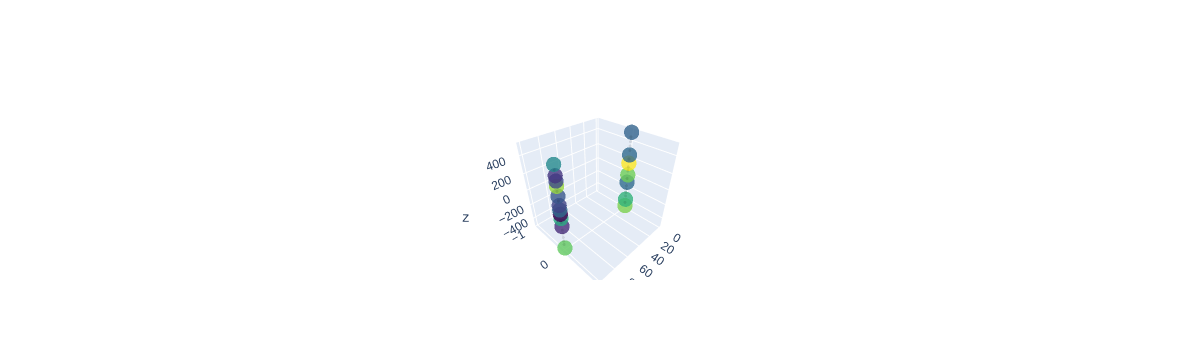

In [114]:
plot_event(det, hit_times_coinc)

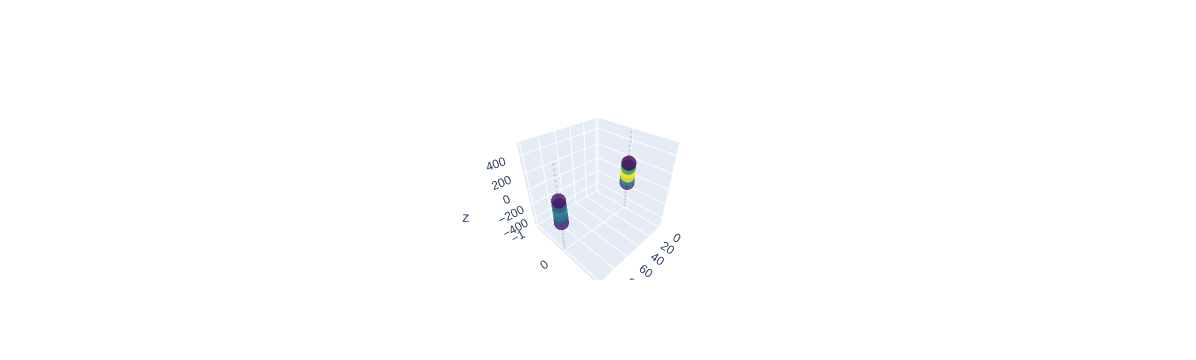

In [120]:
hit_times, rec = generate_cascade(det, np.asarray([10., 10., 0.]), 0, energy=1E4,)
hit_times_coinc = coinc(hit_times)
plot_event(det, hit_times)

<AxesSubplot:ylabel='Count'>

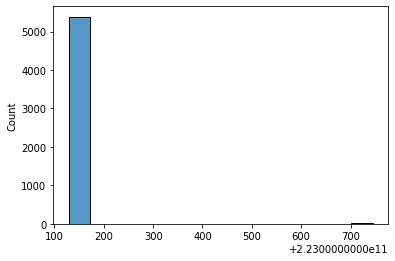

In [22]:
sns.histplot(np.asarray(event[20]))

In [86]:
np.asarray(event[1]).min()- np.asarray(event[1]).max()


-3.202911376953125

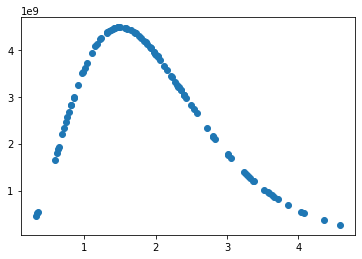

In [69]:
plt.plot(times, amps, "o")